Power consumed in the trip: 356.79 kWh
Trip distance: 35.75 km
Average speed for the trip: 43.94 km/h
Required Motor Rating: 305.90 kw
30.53
43.13
39.60
45.93
33.95
40.19
33.26
41.05
42.11
34.76
39.72
43.26
31.61
45.00
43.16
44.49
36.40
41.83
36.99
45.78
59.24
33.59
60.72
49.76


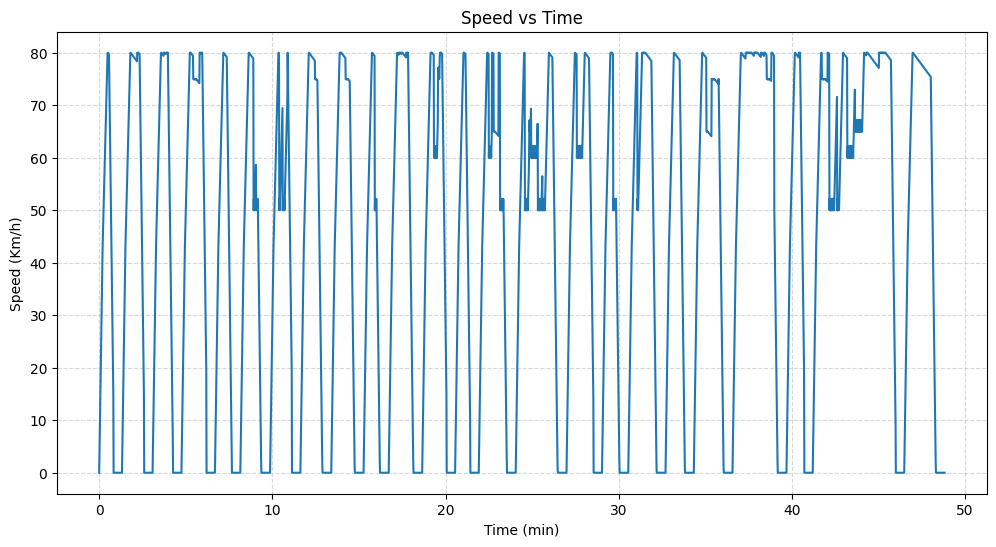

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from average_speed_calculator import AverageSpeedCalculator
from power_consumption_calculator import PowerConsumptionCalculator
from motor_rating_calculator import MotorRatingCalculator
from csv_loader import CSVLoader  # Import the new CSVLoader class

class TrainSimulation:
    def __init__(self, train_params_dict, stations, curves, gradients, speed_restrictions):
        self.train_params = train_params_dict
        self.stations = stations
        self.curves = curves
        self.gradients = gradients
        self.speed_restrictions = speed_restrictions

        # Simulation state variables
        self.distance = 0
        self.time = 0
        self.speed = 0
        self.distance_log = [0]
        self.time_log = [0]
        self.speed_log = [0]
        self.segment_distance_log = [0]
        self.section_time_log = []
        self.section_avg_speed_log = []

        # Initialize calculators
        self.average_speed_calculator = AverageSpeedCalculator()
        self.power_calculator = PowerConsumptionCalculator(
            float(self.train_params['Train_mass']), 
            float(self.train_params['Regeneration_efficiency'])
        )
        self.motor_rating = MotorRatingCalculator(self.train_params)

        # Precompute essential values
        self._compute_derived_values()
        return

    def _compute_derived_values(self):
        """Derive initial simulation values from input parameters."""
        self.no_coasting = not self.train_params['Coasting']
        self.max_speed = float(self.train_params['Maximum_speed']) * 1000 / 3600
        self.switch_speed = float(self.train_params['Switch_speed']) * 1000 / 3600
        self.station_chainages = self.stations['Chainage'].values
        self.station_names = self.stations['Station_Name'].values
        self.accelerating_distance = self.max_speed**2 / (2 * float(self.train_params['Acceleration_switch']))
        self.braking_distance = self.max_speed**2 / (2 * float(self.train_params['Braking_deceleration']))
        self.min_run_distance = self.accelerating_distance + self.braking_distance
        self.train_mass = float(self.train_params['Train_mass'])
        self.stop_duration = int(self.train_params['Stop_duration'])
        self.acceleration = float(self.train_params['Acceleration'])
        self.acceleration_switch = float(self.train_params['Acceleration_switch'])
        self.coasting_limit = float(self.train_params['Coasting_limit'])
        self.braking_deceleration = float(self.train_params['Braking_deceleration'])
        self.speed_limit_dict = pd.Series(self.speed_restrictions['Speed_Limit'].values, 
                                          index=self.speed_restrictions['Radius']).to_dict()
        return

    def _davis_formula(self, speed):
        """Calculate train resistance using the Davis formula."""
        static_friction = float(self.train_params['Static_friction'])
        rolling_resistance = float(self.train_params['Rolling_resistance'])
        air_resistance = float(self.train_params['Air_resistance'])
        return (static_friction + rolling_resistance * speed + air_resistance * speed**2) * self.train_mass

    def _log_simulation_data(self):
        """Log current simulation data."""
        self.distance += self.speed
        self.distance_log.append(self.distance / 1000)  # Distance in km
        self.time_log.append(self.time / 60)  # Time in minutes
        self.speed_log.append(self.speed * 18 / 5)  # Speed in km/h
        return

    def accelerate(self, acceleration, time_step=1):
        """Handle acceleration phase."""
        self.speed += acceleration * time_step
        if self.speed > self.max_speed:
            self.speed = self.max_speed
        self.power_calculator.log_power_during_acceleration(self.speed, acceleration)
        self.time += time_step
        self._log_simulation_data()
        return

    def coast(self, time_step=1):
        """Handle coasting phase."""
        if self.no_coasting:
            self.time += time_step
            self._log_simulation_data()
            return

        mass_kg = self.train_mass * 1000
        resistance = self._davis_formula(self.speed)
        deceleration = resistance / mass_kg

        self.speed -= deceleration * time_step if self.speed > 0 else 0
        self.time += time_step
        self._log_simulation_data()
        return

    def get_speed_restriction(self, time_step=1):
        """Apply speed restriction if within a curve."""
        for _, curve in self.curves.iterrows():
            if curve['Start'] <= self.distance <= curve['End']:
                self.speed = self.speed_limit_dict.get(curve['Radius']) * 1000 / 3600
                self.time += time_step
                self._log_simulation_data()
        return

    def brake(self, time_step=1):
        """Handle braking phase."""
        self.speed -= self.braking_deceleration * time_step
        if self.speed < 0:
            self.speed = 0
        self.power_calculator.log_power_during_braking(self.speed, self.braking_deceleration)
        self.time += time_step
        self._log_simulation_data()
        return

    def accelerate_phase(self):
        """Execute the acceleration phase."""
        while self.distance < self.cumulative_distance + self.accelerating_distance:
            acceleration = self.acceleration if self.speed < self.switch_speed else self.acceleration_switch
            self.accelerate(acceleration, 1)
            if self.speed >= self.max_speed:
                break
        return

    def coasting_phase(self):
        """Execute the coasting phase."""
        should_accelerate = False
        while self.distance < (self.cumulative_distance + self.segment_distance - self.braking_distance):
            if self.speed > self.coasting_limit * self.max_speed and not should_accelerate:
                self.coast(1)
            else:
                should_accelerate = True
                self.accelerate(self.acceleration_switch, 1)

            if self.speed >= self.max_speed:
                self.speed = self.max_speed
                should_accelerate = False

            self.get_speed_restriction(1)
        return

    def braking_phase(self):
        """Execute the braking phase."""
        while self.distance < self.cumulative_distance + self.segment_distance:
            self.brake(1)
            if self.speed <= 0:
                break
        return

    def station_stop_phase(self):
        """Handle the stop phase at a station."""
        self.speed = 0
        for _ in range(self.stop_duration):
            self.time += 1
            self._log_simulation_data()
        return

    def train_trip(self):
        """Simulate the train trip through all stations."""
        for i in range(len(self.station_names) - 1):
            self.segment_distance = self.station_chainages[i + 1] - self.station_chainages[i]
            self.cumulative_distance = sum(self.segment_distance_log)
            self.segment_distance_log.append(self.segment_distance)

            time_segment_start = self.time

            self.accelerate_phase()
            self.coasting_phase()
            self.braking_phase()
            self.station_stop_phase()

            time_segment_end = self.time
            self.section_time_log.append(time_segment_end - time_segment_start)
            self.section_avg_speed_log.append(self.segment_distance / (time_segment_end - time_segment_start) * 18 / 5)

        print(f'Power consumed in the trip: {self.power_calculator.calculate_energy_consumed():.2f} kWh')
        print(f'Trip distance: {self.distance / 1000:.2f} km')
        print(f'Average speed for the trip: {self.distance / self.time * 18 / 5:.2f} km/h')
        print(f'Required Motor Rating: {self.motor_rating.display_motor_rating():.2f} kw')
        [print(f'{float(i):.2f}') for i in self.section_avg_speed_log]
        return

    def run_simulation(self):
        """Run the simulation and plot the results."""
        plt.figure(figsize=(12, 6))
        plt.plot(self.time_log, self.speed_log)
        plt.title('Speed vs Time')
        plt.xlabel('Time (min)')
        plt.ylabel('Speed (Km/h)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        return
        
#----------------------------------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    csv_loader = CSVLoader()
    csv_files = [
        ('train_parameters.csv', 'train_params'),
        ('stations.csv', 'stations'),
        ('curves.csv', 'curves'),
        ('gradients.csv', 'gradients'),
        ('sr.csv', 'speed_restrictions')
    ]
    data_dict = csv_loader.load_csv_list(csv_files)

    train_params = data_dict['train_params']
    stations = data_dict['stations']
    curves = data_dict['curves']
    gradients = data_dict['gradients']
    speed_restrictions = data_dict['speed_restrictions']

    simulation = TrainSimulation(train_params, stations, curves, gradients, speed_restrictions)
    simulation.train_trip()
    simulation.run_simulation()
